<a href="https://colab.research.google.com/github/Lazy-pygmy/Dog-breed-prediction/blob/main/Dog_Breed_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"alexandertahlokpui","key":"c3f1ef74d4ce2bf88ca67eb5e9bd8248"}'}

In [13]:
!pip install -q kaggle

In [14]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [15]:
!mkdir dog_dataset
%cd dog_dataset

/content/dog_dataset


In [16]:
!kaggle datasets list -s dogbreedidfromcomp

ref                                title                         size  lastUpdated                 downloadCount  voteCount  usabilityRating  
---------------------------------  ----------------------  ----------  --------------------------  -------------  ---------  ---------------  
catherinehorng/dogbreedidfromcomp  dog-breed-id-from-comp   724495926  2020-06-26 03:09:05.433000           7913         10  0.1764706        


In [17]:
!kaggle datasets download catherinehorng/dogbreedidfromcomp
%cd ..

Dataset URL: https://www.kaggle.com/datasets/catherinehorng/dogbreedidfromcomp
License(s): unknown
 98% 677M/691M [00:11<00:00, 128MB/s]
100% 691M/691M [00:11<00:00, 60.8MB/s]
/content


In [18]:
!unzip dog_dataset/dogbreedidfromcomp.zip -d dog_dataset
!rm dog_dataset/dogbreedidfromcomp.zip
!rm dog_dataset/sample_submission.csv

Streaming output truncated to the last 5000 lines.
  inflating: dog_dataset/train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: dog_dataset/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: dog_dataset/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: dog_dataset/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: dog_dataset/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: dog_dataset/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: dog_dataset/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: dog_dataset/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: dog_dataset/train/83fad0718581a696132c96c166472627.jpg  
  inflating: dog_dataset/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: dog_dataset/train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: dog_dataset/train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: dog_dataset/train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: dog_dataset/train/840db91b

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from keras.preprocessing import image
from tensorflow.keras import regularizers
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [20]:
labels_all = pd.read_csv('dog_dataset/labels.csv')
print(labels_all.shape)
labels_all.head()

(10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [21]:
breeds_all = labels_all['breed']
breed_counts = breeds_all.value_counts()
breed_counts.head()

,count
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114


In [22]:
CLASS_NAME = ['scottish_deerhound', 'maltese_dog', 'bernese_mountain_dog']
labels = labels_all[(labels_all['breed'].isin(CLASS_NAME))]
labels.head()

,id,breed
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
12,00693b8bc2470375cc744a6391d397ec,maltese_dog
79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
90,022b34fd8734b39995a9f38a4f3e7b6b,maltese_dog
118,02d54f0dfb40038765e838459ae8c956,bernese_mountain_dog


In [23]:
#Creating numpy matix with zeros
X_data = np.zeros((len(labels), 224, 224, 3), dtype='float32')

#One hot encoding
Y_data = label_binarize(labels['breed'], classes = CLASS_NAME)

# Reading and converting image to numpy array and normalizing dataset
for i in tqdm(range(len(labels))):
  img = image.load_img(f'dog_dataset/train/{labels.iloc[i]["id"]}.jpg', target_size=(224, 224))
  img = image.img_to_array(img)
  x = np.expand_dims(img.copy(), axis=0)
  X_data[i] = x / 225.0

# Printing train image and one hot encode shape & size
print ('\ntrain Images shpae: ', X_data.shape, ' size{:,}'.format(X_data.size))
print('One-hot encoded output shape: ',Y_data.shape,' size{:,}'.format(Y_data.size))

100%|██████████| 357/357 [00:00<00:00, 408.73it/s]


train Images shpae:  (357, 224, 224, 3)  size53,738,496
One-hot encoded output shape:  (357, 3)  size1,071


In [24]:
model = Sequential()

model.add(Conv2D(filters= 64, kernel_size = (5,5), activation = 'relu', input_shape = (224, 224,3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu',
                 kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPool2D(pool_size=(2,2)))


model.add(Conv2D(filters=16, kernel_size=(7, 7), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=8, kernel_size=(5, 5), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(len(CLASS_NAME), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 220, 220, 64)   │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 108, 108, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 16)     │        25,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 20, 20, 8)      │         3,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       102,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 162,619 (635.23 KB)

 Trainable params: 162,619 (635.23 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Spitting the data set into training and testing data sets
X_train_and_val, X_test, Y_train_and_val, Y_test = train_test_split(X_data, Y_data, test_size= 0.1)

# Spitting the training data set into training and validation data sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train_and_val, Y_train_and_val, test_size=0.2)

In [26]:
epochs = 100
batch_size = 128

history = model.fit(X_train, Y_train, batch_size= batch_size, epochs = epochs, validation_data = (X_val, Y_val))

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 45s 21s/step - accuracy: 0.3958 - loss: 4.8996 - val_accuracy: 0.3538 - val_loss: 4.8787
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 76s 21s/step - accuracy: 0.3750 - loss: 4.8674 - val_accuracy: 0.3538 - val_loss: 4.8548
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 39s 19s/step - accuracy: 0.3724 - loss: 4.8422 - val_accuracy: 0.3538 - val_loss: 4.8307
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 19s/step - accuracy: 0.3698 - loss: 4.8175 - val_accuracy: 0.3538 - val_loss: 4.8065
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 18s/step - accuracy: 0.3828 - loss: 4.7869 - val_accuracy: 0.3538 - val_loss: 4.7824
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 36s 21s/step - accuracy: 0.3776 - loss: 4.7615 - val_accuracy: 0.3538 - val_loss: 4.7579
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 39s 19s/step - accuracy: 0.3724 - loss: 4.7358 - val_accuracy: 0.3538 - val_loss: 4.7322
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 42s 19s/step - accuracy: 0.3646 - loss: 4.7125 - val_accuracy: 0.3538 - val_loss:

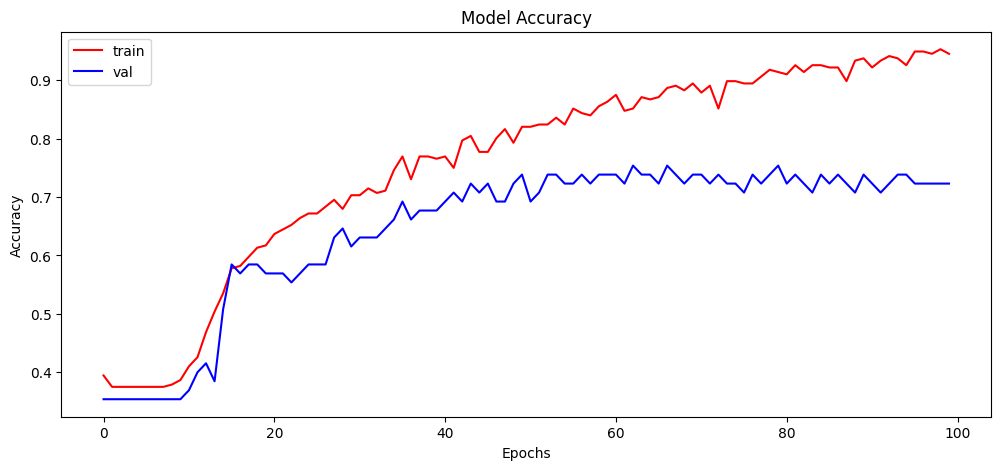

In [30]:
plt.figure(figsize = (12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

In [29]:
Y_pred = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
print('Accuracy over the test set: \n', round((score[1]*100), 2), '%')

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 259ms/step - accuracy: 0.7604 - loss: 3.2746
Accuracy over the test set: 
 75.0 %


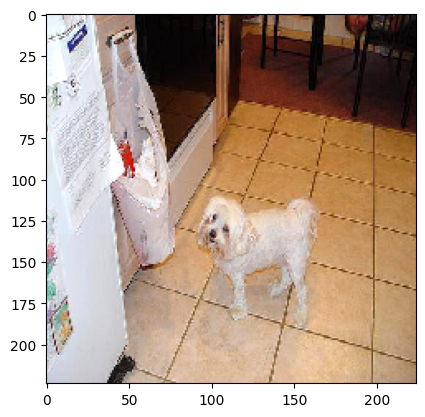

Oringinally:  maltese_dog
Oringinally:  maltese_dog


In [33]:
plt.imshow(X_test[1,:,:,:])
plt.show()

print('Oringinally: ', labels['breed'].iloc[np.argmax(Y_test[1])])
print('Oringinally: ', labels['breed'].iloc[np.argmax(Y_test[1])])

In [34]:
model.save('dog_breed.h5')